In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
from keras.optimizers import Adam
from keras.losses import MSE

from sklearn.metrics import mean_absolute_percentage_error


### Import the dataset and processing data

In [2]:
df = yf.download("GC=F")
df['Returns'] = df['Adj Close'] - df['Open']
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Returns
Date,,,,,,,
2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0,0.000000
2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0,3.500000
2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0,0.000000
2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2,0.000000
2000-09-06,274.200012,274.200012,274.200012,274.200012,274.200012,0,0.000000
...,...,...,...,...,...,...,...
2023-10-02,1844.099976,1845.900024,1826.699951,1830.000000,1830.000000,2309,-14.099976
2023-10-03,1825.000000,1830.900024,1816.800049,1824.599976,1824.599976,310,-0.400024
2023-10-04,1821.800049,1828.199951,1816.400024,1818.500000,1818.500000,357,-3.300049


In [3]:
fig = px.line(df,y='Open',x=df.index,
              title='Gold Price History Data')
fig.show()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5796 entries, 2000-08-30 to 2023-10-06
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5796 non-null   float64
 1   High       5796 non-null   float64
 2   Low        5796 non-null   float64
 3   Close      5796 non-null   float64
 4   Adj Close  5796 non-null   float64
 5   Volume     5796 non-null   int64  
 6   Returns    5796 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 362.2 KB


In [5]:
fig = px.scatter_matrix(df,
                        dimensions=['Open','High','Low','Close','Volume'],
                        color='Volume')
fig.show()

In [6]:
df.index = pd.to_datetime(df.index)
df

,Open,High,Low,Close,Adj Close,Volume,Returns
Date,,,,,,,
2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0,0.000000
2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0,3.500000
2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0,0.000000
2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2,0.000000
2000-09-06,274.200012,274.200012,274.200012,274.200012,274.200012,0,0.000000
...,...,...,...,...,...,...,...
2023-10-02,1844.099976,1845.900024,1826.699951,1830.000000,1830.000000,2309,-14.099976
2023-10-03,1825.000000,1830.900024,1816.800049,1824.599976,1824.599976,310,-0.400024
2023-10-04,1821.800049,1828.199951,1816.400024,1818.500000,1818.500000,357,-3.300049


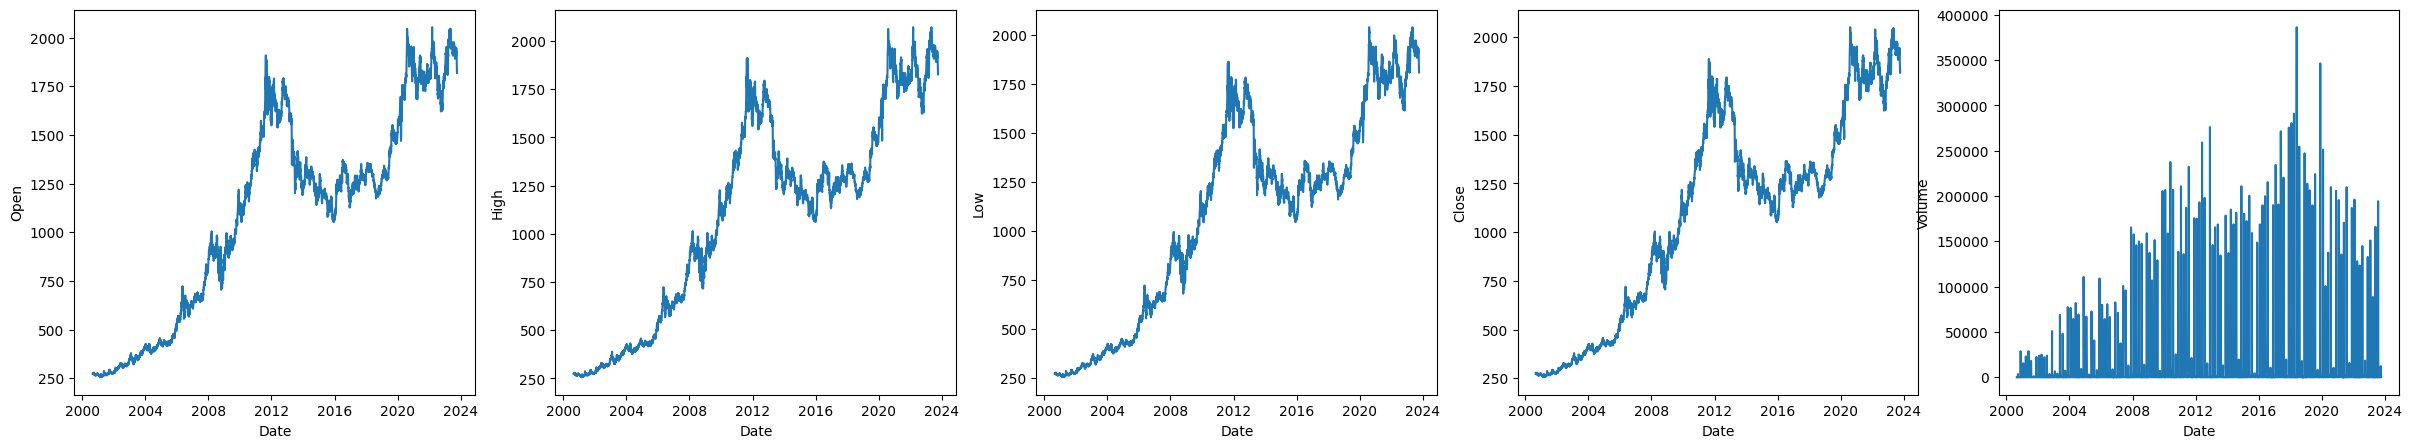

In [7]:
fig, axes = plt.subplots(1, 5, figsize = (30, 5))
axes = axes.flatten()

sns.lineplot(ax = axes[0], x = df.index, y = df["Open"]);
sns.lineplot(ax = axes[1], x = df.index, y = df["High"]);
sns.lineplot(ax = axes[2], x = df.index, y = df["Low"]);
sns.lineplot(ax = axes[3], x = df.index, y = df["Close"]);
sns.lineplot(ax = axes[4], x = df.index, y = df["Volume"]);

In [8]:
fig = px.scatter(df, x=df.index, y=['Returns'])
fig.show()

In [9]:
fig = px.scatter(df, x=df.index, y=['Open','Close'])
fig.show()

In [10]:
fig = px.histogram(df, x=df.index, y='Volume', text_auto = True, hover_data  = df.columns)
fig.show()

In [11]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Returns
count,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000
mean,1099.415390,1104.872775,1093.620325,1099.312388,1099.312388,4284.712905,-0.103003
std,525.936195,528.858304,522.797028,525.861346,525.861346,24403.102441,11.126539
min,255.000000,256.100006,255.000000,255.100006,255.100006,0.000000,-117.599976
25%,605.074982,607.375000,605.750000,604.975006,604.975006,20.000000,-3.299988
50%,1215.549988,1222.450012,1209.950012,1217.050049,1217.050049,104.000000,0.000000
75%,1507.124969,1513.274994,1497.925018,1506.299957,1506.299957,393.000000,3.600006
max,2053.600098,2072.000000,2040.000000,2051.500000,2051.500000,386334.000000,73.500000


In [12]:
Train_data = df[:4000][['Open','High','Low','Close','Returns']]
Test_data = df[4000:][['Open','High','Low','Close','Returns']]


In [13]:
# Create the plot
fig = px.line()
fig.add_scatter(x=Train_data.index, y=Train_data['Open'], name='Train data')
fig.add_scatter(x=Test_data.index, y=Test_data['Open'], name='Test data')
fig.show()

In [14]:
x_train = Train_data
y_train = Train_data['Open']
X_test = Test_data
Y_test = Test_data['Open']

In [15]:
print('X_train Shape: ', x_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', Y_test.shape)

X_train Shape:  (4000, 5)
y_train Shape:  (4000,)
X_test Shape:   (1796, 5)
y_test Shape:   (1796,)


### Create model 

In [16]:
def Model(opt,loss,metrics):
    Model = Sequential()
    Model.add(LSTM(units=40,activation='relu', return_sequences=True, input_shape=(None,1))),
    Model.add(LSTM(512, activation='relu', return_sequences=True)),
    Model.add(LSTM(32, activation='relu', return_sequences=False)),
    Model.add(Dense(16,activation='relu'))
    Model.add(Dense(1,activation='linear'))
    Model.compile(optimizer=opt, loss=loss,metrics=[metrics])
    Model.summary()
    
    return Model

### Train model

In [17]:
auto_lr = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.00001, decay_rate=1e-6, decay_steps=1, staircase=False)

In [18]:
model = Model(opt=Adam(learning_rate=auto_lr),loss=MSE ,metrics='mae')
history = model.fit(x_train, y_train, validation_split=0.2, epochs=50)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 40)          6720      
                                                                 
 lstm_1 (LSTM)               (None, None, 512)         1132544   
                                                                 
 lstm_2 (LSTM)               (None, 32)                69760     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1209569 (4.61 MB)
Trainable params: 1209569 (4.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
100/100

In [19]:
fig = px.line(title='Loss')
fig.add_scatter(y=history.history['loss'], name='loss')
fig.add_scatter(y=history.history['val_loss'], name='val_loss')
fig.show()


In [20]:
preform = model.predict(X_test)

loss = model.evaluate(X_test,Y_test)
MAPE = mean_absolute_percentage_error(Y_test,preform)
Accury = 1-MAPE

57/57 [==============================] - 1s 6ms/step - loss: 1.4074 - mae: 0.7550


In [21]:
print('Loss : ', loss[0])
print('MAPE : ', MAPE)
print('Accury : ', Accury)

Loss :  1.4073593616485596
MAPE :  0.00047412621405434766
Accury :  0.9995258737859457


In [22]:
def Predict_data(data_input, Data_slide):
    predictions = []
    for i in range(len(data_input) + Data_slide):
        if i < len(data_input):
            X_pred = data_input[i:i + 1]
        else:
            X_pred = data_input[-1:]
        predictions.append(model.predict(X_pred)[0])
    return np.array(predictions)

In [23]:
predictions = Predict_data(data_input=X_test,Data_slide=1)

1/1 [==============================] - 0s 10ms/step


In [24]:
predictions = pd.DataFrame(predictions)
predictions

,0
0,1335.915039
1,1342.395630
2,1345.341553
3,1351.085693
4,1351.007202
...,...
1792,1824.796753
1793,1821.795166
1794,1825.653564
1795,1819.523560


In [25]:
fig = px.line(title='Predict vs Actual')
fig.add_scatter(x=Y_test.index, y=Y_test, name='Actual Open')
fig.add_scatter(x=Y_test.index, y=predictions[0], name='Predict')
fig.show()

In [26]:
fig = px.line(title='Predict')
fig.add_scatter(y=predictions[0], name='Open')
fig.show()

In [28]:
fig = px.line(title='Predict vs Data')
fig.add_scatter(x=Train_data.index, y=Train_data['Open'], name='data open')
fig.add_scatter(x=Y_test.index, y=Y_test, name='Actual Open')
fig.add_scatter(x=Y_test.index, y=predictions[0], name='Open')
fig.show()